In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt

Draw sampling

In [2]:
def draw_samp(n,theta,sigma,seed=16):
    np.random.seed(seed)
    ind_clus=np.diag(np.sign(np.random.uniform(low=0.0, high=1.0, size=n)-0.5))
    samp=np.random.normal(ind_clus@np.repeat(theta,n,axis=0),np.repeat(sigma,n,axis=0))
    return samp

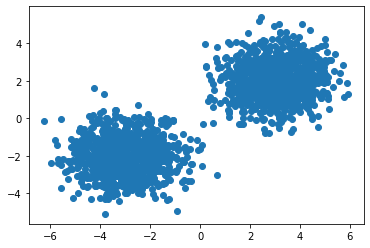

In [3]:
kkk=draw_samp(2000,np.array([[3,2]]),np.array([[1,1]]))
#kkk=draw_samp(2000,np.array([[0,0]]),np.array([[1,1]]))
plt.scatter(kkk[:,0],kkk[:,1])

Define functions

In [4]:
def normal_pdfs(samp,theta,sigma):

    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    log_pdf_pos=np.sum(norm.logpdf(samp,theta,sigma),axis=1)
    log_pdf_neg=np.sum(norm.logpdf(samp,-theta,sigma),axis=1)
    pdf_pos=np.reshape(np.exp(log_pdf_pos),(n,1))
    pdf_neg=np.reshape(np.exp(log_pdf_neg),(n,1))

    
    return pdf_pos, pdf_neg


def L(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    L_value
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    L_val=np.mean(np.log(0.5*pdf_pos+0.5*pdf_neg))
    
    return L_val



def dL_theta(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    derivative of theta
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    nomi=0.5*pdf_pos*(-(theta-samp)/(sigma**2))+0.5*pdf_neg*(-(theta+samp)/(sigma**2))
    deno1=(0.5*pdf_pos+0.5*pdf_neg)
    #deno2=np.reshape(deno1,(n,1))
    deno=np.repeat(deno1,d,axis=1)
    res=np.mean(nomi/deno,axis=0)
    
    return res

def dL_sigma_theta(samp,theta,sigma,pdf_pos,pdf_neg):
    """
    dL_sigma*dsigma_theta
    theta:mean
    nu: precision
    """
    #samp=draw_samp(100,theta_star,sigma_star)
    d=np.size(theta)
    n=np.shape(samp)[0]
    theta=np.repeat(theta,n,axis=0)
    sigma=np.repeat(sigma,n,axis=0)
    
    nomi_pos=-pdf_pos/sigma+pdf_pos*(samp-theta)**2/(sigma**3)
    nomi_neg=-pdf_neg/sigma+pdf_neg*(samp+theta)**2/(sigma**3)
    nomi=0.5*nomi_pos+0.5*nomi_neg
    deno1=(0.5*pdf_pos+0.5*pdf_neg)
    deno=np.repeat(deno1,d,axis=1)
    
    dsigma_theta=-theta/sigma
    
    res=np.mean(nomi/deno*dsigma_theta,axis=0)
    
    return res



In [30]:
def adaEGD(iteration,theta0,theta_star,sigma_star,eta,beta,samp):
    
    theta=theta0
    theta_hat=theta
    sigma=np.sqrt(1-theta**2)
    
    DIFF_theta=np.array([])
    DIFF_sigma=np.array([])
    
    pdf_pos,pdf_neg=normal_pdfs(samp,theta,sigma)
    L1=L(samp,theta,sigma,pdf_pos,pdf_neg)
    optimal_iter=-1
    
    for i in range(iteration):
        
        DIFF_theta=np.append(DIFF_theta,np.linalg.norm(theta-theta_star))
        #DIFF_theta=np.append(DIFF_theta,np.linalg.norm(theta-theta_hat))
        DIFF_sigma=np.append(DIFF_sigma,np.linalg.norm(sigma-sigma_star))
        
        
        pdf_pos,pdf_neg=normal_pdfs(samp,theta,sigma)
        DLN_theta=dL_theta(samp,theta,sigma,pdf_pos,pdf_neg)+dL_sigma_theta(samp,theta,sigma,pdf_pos,pdf_neg)
    
        theta=theta+eta/(beta**i)*DLN_theta
        sigma=np.sqrt(1-theta**2)
        
        L2=L(samp,theta,sigma,pdf_pos,pdf_neg)
        
        if L2>L1:
            theta_hat=theta
            L1=L2
            optimal_iter=i
        
    return DIFF_theta, DIFF_sigma,theta_hat,optimal_iter

In [72]:
theta_star=np.array([[0,0,0]])
sigma_star=np.array([[1,1,1]])

theta_star=np.array([[0,0]])
sigma_star=np.array([[1,1]])

#theta_star=np.array([[0]])
#sigma_star=np.array([[1]])

Text(0, 0.5, 'log ||theta-theta*||')

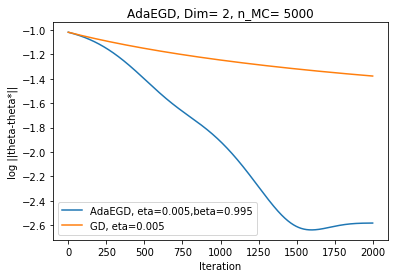

In [88]:
iteration=2000

theta0=np.array([[0.5,0.6,0.7]]) #initial
theta0=np.array([[0.3,0.2]]) #initial
#theta0=np.array([[0.3]]) #initial
beta=0.995
eta=0.005
d=np.size(theta0)

n_samp=5000

samp=draw_samp(n_samp,theta_star,sigma_star)

DIFF_adagrad_theta,DIFF_adagrad_sigma,theta_hat,optimal_iter=adaEGD(iteration,theta0,theta_star,sigma_star,eta,beta,samp)
DIFF_GD_theta,DIFF_GD_sigma,theta_hat_GD,optimal_iter_GD=adaEGD(iteration,theta0,theta_star,sigma_star,eta,1,samp)
plt.plot(range(iteration), np.log(DIFF_adagrad_theta), label='AdaEGD, eta={eta:.3f},beta={beta:.3f}'.format(eta=eta,beta=beta))
plt.plot(range(iteration), np.log(DIFF_GD_theta), label='GD, eta={eta:.3f}'.format(eta=eta))
plt.legend()
plt.title("AdaEGD, Dim={dim: d}, n_MC={N_samp: d}".format(dim=d,N_samp=n_samp))
plt.xlabel('Iteration')
plt.ylabel('log ||theta-theta*||')

In [75]:
theta_hat

array([[0.0407549 , 0.06381948]])

In [59]:
theta_hat_GD

array([[0.04174605, 0.08257128, 0.19809946]])

In [60]:
optimal_iter

499

In [61]:
optimal_iter_GD

499